
### MRI AND CT SCAN MODEL



---

Imports 

---


In [12]:
import importlib
import pipeline as pl
importlib.reload(pl)
import model as ml
importlib.reload(ml)

import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import keras_tuner
from kerastuner.tuners import Hyperband

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.19.0


---

Load Augmented data from pipeline

---

In [13]:
csv_path = "MRI and CT.csv"
train, test,val = pl.loadprocesseddata(csv_path)

Found 18750 validated image filenames belonging to 5 classes.
Found 3125 validated image filenames belonging to 5 classes.
Found 3125 validated image filenames belonging to 5 classes.


---

Build Model

---

In [14]:
def build_cnn_model(hp, n_classes=5):
    activation = hp.Choice("activation", values=["relu", "tanh", "elu"])
    n_conv_layers = hp.Int("n_conv_layers", min_value=2, max_value=5, step=1)
    n_filters = hp.Int("n_filters", min_value=8, max_value=64, step=8)
    
    kernel_size_val = hp.Choice("kernel_size", values=[3, 5])
    pool_size_val = hp.Choice("pool_size", values=[2, 3])
    
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="log")
    decay_steps = hp.Int("decay_steps", min_value=1000, max_value=10000, step=1000)
    decay_rate = hp.Float("decay_rate", min_value=0.9, max_value=0.999, step=0.001)
    dropout_rate = hp.Float("dropout_rate", min_value=0.2, max_value=0.5, step=0.1)
    batch_norm = hp.Choice("batch_norm", values=[True, False])
    optimizer_choice = hp.Choice("optimizer", values=["sgd", "RMSprop", "adam", "AdamW"])
    
    expon_dec = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate
    )
    if optimizer_choice == "sgd":
        optimizer = keras.optimizers.SGD(learning_rate=expon_dec)
    elif optimizer_choice == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=expon_dec)
    else:
        optimizer = keras.optimizers.Adam(learning_rate=expon_dec)
    
    model = keras.Sequential()
    
    model.add(layers.Conv2D(
        filters=n_filters,
        kernel_size=(kernel_size_val, kernel_size_val),
        activation=activation,
        input_shape=(64, 64, 3),
        padding='same'
    ))
    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(pool_size_val, pool_size_val)))
    
    for i in range(n_conv_layers - 1):
        model.add(layers.Conv2D(
            filters=n_filters * (2**i),
            kernel_size=(kernel_size_val, kernel_size_val),
            activation=activation,
            padding='same'
        ))
        if batch_norm:
            model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(pool_size_val, pool_size_val)))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.GlobalAveragePooling2D())
    
    n_dense_units = hp.Int("n_dense_units", min_value=32, max_value=256, step=32)
    model.add(layers.Dense(units=n_dense_units, activation=activation))
    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(n_classes, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model


---

Hyperband Search

---

In [15]:
tuner = Hyperband(
    lambda hp: build_cnn_model(hp),
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='hyperbanding-ScanTypes',
    project_name='MRI&CT')

Reloading Tuner from hyperbanding-ScanTypes\MRI&CT\tuner0.json


In [19]:
tuner.search(train, epochs=10, validation_data=val)

Trial 21 Complete [00h 07m 21s]
val_accuracy: 0.8540800213813782

Best val_accuracy So Far: 0.8550400137901306
Total elapsed time: 3d 09h 50m 00s


In [16]:
best_model = tuner.get_best_models(num_models=1)[0]

c:\Users\ckell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\ckell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 21 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


---

Train Best Model

---

In [17]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=35,
    restore_best_weights=True)

In [20]:
history = best_model.fit(
    train,
    epochs=200,
    validation_data=val,
    callbacks=[early_stopping])

Epoch 1/200
586/586 ━━━━━━━━━━━━━━━━━━━━ 65s 109ms/step - accuracy: 0.7995 - loss: 0.4892 - val_accuracy: 0.8758 - val_loss: 0.3281
Epoch 2/200
586/586 ━━━━━━━━━━━━━━━━━━━━ 60s 101ms/step - accuracy: 0.8320 - loss: 0.4190 - val_accuracy: 0.8755 - val_loss: 0.3329
Epoch 3/200
586/586 ━━━━━━━━━━━━━━━━━━━━ 59s 100ms/step - accuracy: 0.8420 - loss: 0.3961 - val_accuracy: 0.8563 - val_loss: 0.3674
Epoch 4/200
586/586 ━━━━━━━━━━━━━━━━━━━━ 69s 117ms/step - accuracy: 0.8500 - loss: 0.3883 - val_accuracy: 0.8758 - val_loss: 0.3255
Epoch 5/200
586/586 ━━━━━━━━━━━━━━━━━━━━ 70s 118ms/step - accuracy: 0.8514 - loss: 0.3761 - val_accuracy: 0.8925 - val_loss: 0.2850
Epoch 6/200
586/586 ━━━━━━━━━━━━━━━━━━━━ 76s 128ms/step - accuracy: 0.8561 - loss: 0.3633 - val_accuracy: 0.8733 - val_loss: 0.4349
Epoch 7/200
586/586 ━━━━━━━━━━━━━━━━━━━━ 77s 130ms/step - accuracy: 0.8597 - loss: 0.3532 - val_accuracy: 0.8819 - val_loss: 0.3883
Epoch 8/200
586/586 ━━━━━━━━━━━━━━━━━━━━ 75s 126ms/step - accuracy: 0.8635 -

---

Plot Learning Curve

---

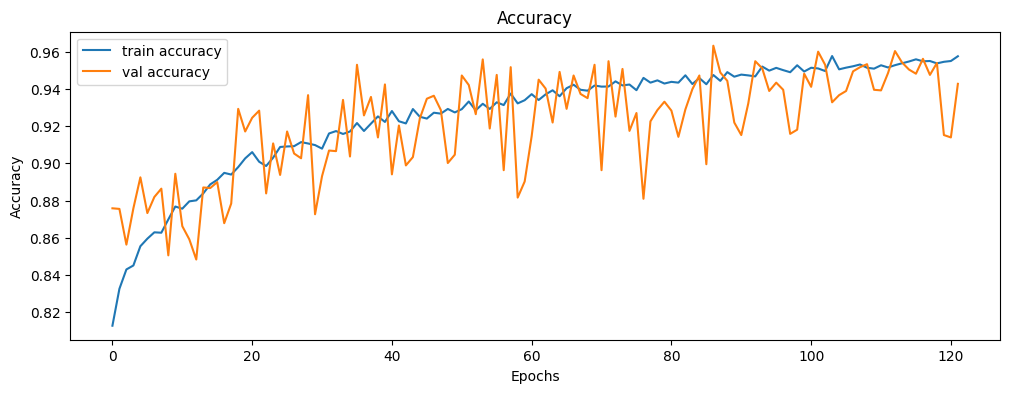

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

---

Obtain Model Metrics

---

In [22]:
y_pred = best_model.predict(test, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test.classes
results = classification_report(y_true, y_pred_classes)
print(results)


98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 299ms/step
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       625
           1       0.96      0.92      0.94       625
           2       0.91      1.00      0.95       625
           3       0.98      0.96      0.97       625
           4       0.96      0.98      0.97       625

    accuracy                           0.96      3125
   macro avg       0.96      0.96      0.96      3125
weighted avg       0.96      0.96      0.96      3125



---

Obtain Val Accuracy

---

In [ ]:
results = best_model.evaluate(val, verbose=1)


98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9602 - loss: 0.1044


---

Save model

---

In [26]:
best_model.save('MRI&CT.keras')
